In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [18, 8]

In [ ]:
rating = pd.read_csv('/kaggle/input/anime-recommendations-database/rating.csv')
anime_df = pd.read_csv('/kaggle/input/anime-recommendations-database/anime.csv')
anime_with_synopsis = pd.read_csv('../input/anime-recommendation-database-2020/anime_with_synopsis.csv')
anime_with_synopsis.drop(['MAL_ID', 'Score', 'Genders'], axis=1, inplace=True)
anime_with_synopsis = anime_with_synopsis.rename(columns={"Name": "name"})
# anime_with_synopsis.head(5)

print('rating shape:', rating.shape)
print('anime_df shape:', anime_df.shape)

In [ ]:
anime_df = anime_df.merge(anime_with_synopsis, on=["name"])
anime_df.head()

 ##### 1) anime_data:
* anime_id - myanimelist.net's unique id identifying an anime.
* name - full name of anime.
* genre - comma separated list of genres for this anime.
* type - movie, TV, OVA, etc.
* episodes - how many episodes in this show. (1 if movie).
* rating - average rating out of 10 for this anime.
* members - number of community members that are in this anime's "group".


##### 2) rating_data:
* user_id - non identifiable randomly generated user id.
* anime_id - the anime that this user has rated.
* rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

# Удаляем null
### Во-первых, нам проще создать систему рекомендаций, если набор данных не имеет значений NULL. Итак, мы удалим значения NULL

In [ ]:
null_features = anime_df.columns[anime_df.isna().any()]
anime_df[null_features].isna().sum()

In [ ]:
anime_df.dropna(inplace=True)

###  Возможно, в названии аниме используется японские буквы или специальные символы, решаем эту пробелему:


In [ ]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    
    return text

anime_df['name'] = anime_df['name'].apply(text_cleaning)

# EDA (Exploratory data analysis)

In [ ]:
type_count = anime_df['type'].value_counts()

sns.barplot(x=type_count.values,
            y=type_count.index,
            palette='magma').set_title('Anime Types')

plt.tight_layout()
plt.show()



In [ ]:
import plotly.graph_objects as go
labels = anime_df['type'].value_counts().index
values = anime_df['type'].value_counts().values
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(
    title={
        'text': "Medium of Streaming",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

## Какие жанры есть в наборе данных аниме?

In [ ]:
from collections import defaultdict

all_genres = defaultdict(int)

for genres in anime_df['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1

In [ ]:
from wordcloud import WordCloud

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)

plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
anime_df[anime_df['episodes'] == 'Unknown']['name'][:5] # те аниме, к-во эпизодов/серий, к-х неизвестно (видимо их очень много)

In [ ]:
# тут вот можем посмотреть на то, какие аниме к-вом серий больше чем 1500
episodes_count = anime_df[anime_df['episodes'] != 'Unknown'][['name', 'episodes']]
episodes_count['episodes'] = pd.to_numeric(episodes_count['episodes'])

episodes_count.query('episodes>1500')

# У какого аниме самый высокий рейтинг?
### Сюда я включила аниме, у которых более 500000 community members
### Топ-5 

In [ ]:
anime_df[['name', 'rating', 'members', 'type']].sort_values(by='rating', ascending=False).query('members>500000')[:5]

# Выведем еще рейтинг для полнометражных фильмов

In [ ]:
anime_df[anime_df['type'] == 'Movie'][['name', 'rating', 'members', 'type']].sort_values(by='rating', ascending=False).query('members>200000')[:5]

# И выведем рейтинг для OVA (Original Animated Video)
#### OVA - это японские анимационные фильмы и сериалы, созданные специально для выпуска в домашних видеоформатах без предварительного показа на телевидении или в кинотеатрах.

In [ ]:
anime_df[anime_df['type'] == 'OVA'][['name', 'rating', 'members', 'type']].sort_values(by='rating', ascending=False).query('members>100000')[:5]

# 1 ЧАСТЬ Content-Based Recommendation-System

#### Content-Based Recommender полагается на схожесть рекомендуемых элементов. Основная идея заключается в том, что если вам понравился предмет, то вам понравится и «похожий» предмет. 

#### Контентный метод также решает проблему холодного старта. Если пользователь впервые посещает платформу, мы еще ничего о нем не знаем. Как дать  отличные рекомендации? 
* Во-первых, порекомендовать самые популярные фильмы. 
* После того, как пользователь посмотрит/нажмет на какой-либо продукт, мы выбирем фильмы с похожим содержанием, чтобы порекомендовать. 

TF - отношение числа вхождений некоторого слова к общему числу слов документа.(просто частота слова в документе.) 
IDF - энверсия частоты, с которой некоторое слово встречается в документах коллекции.
Пример. Предположим, мы ищем в Google «the results of latest European Socccer games». Несомненно, что «the» будет встречаться чаще, чем «Socccer games», но относительная важность Socccer games выше, с точки зрения поискового запроса.

В таких случаях взвешивание TF-IDF сводит на нет влияние часто встречающихся слов при определении важности элемента (документа).

#####  Это даст вам матрицу, в которой каждый столбец представляет слово в обзорном словаре (все слова, которые встречаются хотя бы в одном документе), а каждая строка представляет фильм, как и раньше. Это сделано для уменьшения важности часто встречающихся слов. в обзорах сюжетов и, следовательно, их значимость для расчета окончательной оценки сходства.

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

sypnopsis_str = anime_df['sypnopsis'].str.split(',').astype(str)

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 4), min_df=0)
tfidf_matrix = tfidf.fit_transform(sypnopsis_str)

tfidf_matrix.shape

# tfidf.get_feature_names()

#### Мы видим, что для описания 9800 аниме в нашем наборе данных было использовано 1445801 различных слов.
Имея эту матрицу в руках, мы можем теперь вычислить оценку сходства( с помощью оценки подобия евклидова, Пирсона и косинуса) Нет правильного ответа на вопрос, какая оценка лучше. Разные оценки хорошо работают в разных случаях, и часто бывает полезно поэкспериментировать с разными метриками.

Мы будем использовать косинусное сходство для вычисления числовой величины, обозначающей сходство между двумя аниме. Мы используем показатель подобия косинуса, поскольку он не зависит от величины и его относительно легко и быстро вычислить. Формула такая:

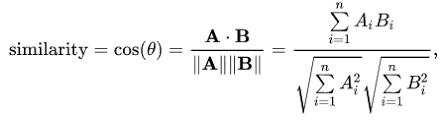


# Cosine-Similarity
Косинусное подобие берет угол между двумя ненулевыми векторами и вычисляет косинус этого угла, и это значение известно как сходство между двумя векторами.
Этот показатель сходства варьируется от 0 до 1, где 0 - самый низкий (наименее похожий), а 1 - самый высокий (самый похожий).
Если угол между двумя векторами равен 0 °, то сходство будет 1. И наоборот, если угол между двумя векторами равен 90 °, то сходство будет равно 0. Для двух векторов с углом больше 90 ° мы также считать их равными 0.

In [ ]:

from sklearn.metrics.pairwise import cosine_similarity


cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

#### Теперь у нас есть матрица попарного косинусного сходства для всех фильмов в наборе данных. Следующим шагом является написание функции, которая возвращает 10 наиболее похожих фильмов на основе оценки косинусного сходства.

## Делаем рекомендацию на основе cosine-similarity

In [ ]:
indices = pd.Series(anime_df.index, index=anime_df['name']) # для того, чтобы получить индекс аниме по его названию

def genre_recommendations(title):
    
            idx = indices[title] # получаем индекс фильма, соответствующий названию
            sim_scores = list(enumerate(cosine_sim[idx])) # получаем оценки попарного сходства всех аниме с этим аниме
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # сортировка аниме по показателям схожести
            sim_scores = sim_scores[1:11] # выводим топ 10
        
        
            anime_indices = [i[0] for i in sim_scores] # получаем индексы этих аниме
            similarity_ = [i[1] for i in sim_scores] 
        
            return pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                                 'Similarity': similarity_,
                                 'Type': anime_df['type'].iloc[anime_indices].values})  # выводим название и жанр аниме
        
  

In [ ]:
%%time
genre_recommendations('Fullmetal Alchemist: Brotherhood')

In [ ]:
%%time
genre_recommendations('Naruto: Shippuuden')

#### Хотя система работает, но качество рекомендации не так уж и высоко (откровенно говоря маленькое:)). Будем использовать не только описание, но и жанры

In [ ]:
genres_str1 = anime_df['genre'].str.split(',').astype(str)
# sypnopsis_str1 = anime_df['sypnopsis'].str.split(',').astype(str)
# unit =  pd.concat([sypnopsis_str1, genres_str1])

tfidf1 = TfidfVectorizer(analyzer='word', ngram_range=(1, 4), min_df=0)
tfidf_matrix1 = tfidf1.fit_transform(genres_str1)

tfidf_matrix1.shape

# # tfidf.get_feature_names()

In [ ]:
cosine_sim1 = cosine_similarity(tfidf_matrix1, tfidf_matrix1)
cosine_sim[:4, :4]

In [ ]:
indices1 = pd.Series(anime_df.index, index=anime_df['name']) # для того, чтобы получить индекс аниме по его названию

def genre_recommendations1(title):
    
            idx = indices1[title] # получаем индекс фильма, соответствующий названию
            sim_scores = list(enumerate(cosine_sim1[idx])) # получаем оценки попарного сходства всех аниме с этим аниме
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # сортировка аниме по показателям схожести
            sim_scores = sim_scores[1:11] # выводим топ 10
        
        
            anime_indices = [i[0] for i in sim_scores] # получаем индексы этих аниме
            similarity_ = [i[1] for i in sim_scores] 
        
            return pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                                 'Similarity': similarity_,
                                 'Type': anime_df['type'].iloc[anime_indices].values})  # выводим название и жанр аниме
        
  

In [ ]:
%%time
genre_recommendations1('Naruto: Shippuuden')

#### О, вот получше будет (хотя выдало похожие аниме, но тут Similarity побольше). Приходим к выводу, что в рекомендациях важно учитывать и жанр. 

#### В целом, вот преимущества использования рекомендаций, основанных на содержании:
* Нет необходимости в данных о других пользователях, поэтому нет проблем с холодным запуском или разреженностью.
* Можно порекомендовать пользователям с уникальными вкусами.
* Можно порекомендовать новые и непопулярные фильмы.

#### Однако у этого подхода есть некоторые недостатки:
* Не рекомендуем элементы, не входящие в профиль содержимого пользователя.
* Невозможно использовать качественные суждения других пользователей.
* Этот метод всегда будет ограничен одним и тем же типом фильма, который пользователь видел в прошлом.

# 2 ЧАСТЬ Collaborative Filtering

# 3 ЧАСТЬ
# Deep Learning для коллаборативной фильтрации
* Нейронные сети - это, по сути, матричные операции.Методы матричной факторизации для рекомендательных систем тоже делают нечто подобное.
* Например: в SVD мы находим матрицы с использованием весов, рассчитанных SGD, что похоже на глубокое обучение.
* С небольшим отрывом, Deep Learning может превзойти SVD

In [ ]:
rating.head()

In [ ]:
rating_count = rating['rating'].value_counts().sort_index()

sns.barplot(x=rating_count.index,
            y=rating_count.values,
            palette='magma').set_title('Comparison of the number of ratings from -1 to 10');

### В реальности многие пользователи не хотят выставлять оценку по какой-либо причине, может быть, потому что они ленивы. -1 означает, что пользователь смотрел аниме, но не присвоил рейтинг, поэтому удаляем это.

In [ ]:

mask = (rating['rating'] == -1)
rating = rating.loc[~mask]
len(rating)

In [ ]:
rating_count = rating['rating'].value_counts().sort_index()

sns.barplot(x=rating_count.index,
            y=rating_count.values,
            palette='magma').set_title('Comparison of the number of ratings from -1 to 10');

In [ ]:
rating = rating[rating['user_id'] < 15000] #сокращаем к-во юзеров

In [ ]:
from sklearn.preprocessing import LabelEncoder #Encode target labels with value between 0 and n_classes-1.

user_enc = LabelEncoder()
rating['user_id'] = user_enc.fit_transform(rating['user_id'])


anime_enc = LabelEncoder()
rating['anime_id'] = anime_enc.fit_transform(rating['anime_id'])


In [ ]:
userid_nunique = rating['user_id'].nunique()
anime_nunique = rating['anime_id'].nunique()

print('К-во уникальных id пользователей:', userid_nunique)
print('К-во уникальных id аниме', anime_nunique)

In [ ]:
### используем только 10000 пользователей, из-за соображений скорости

rating = rating[rating['user_id'] < 10000]

# Строим модель

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Flatten, concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

print('Using tensorflow version:', tf.__version__)

In [ ]:
from sklearn.model_selection import train_test_split

X = rating.drop(['rating'], axis=1)
y = rating['rating']

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.1,
                                                  stratify=y,
                                                  random_state=2020)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

# 1 модель

In [ ]:
def RecommenderV1(n_users, n_movies, n_dim):
    
    # User
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    
    # Movie
    movie = Input(shape=(1,))
    M = Embedding(n_movies, n_dim)(movie)
    M = Flatten()(M)
    
    # Dot U and M
    x = Dot(axes=1)([U, M])
    
    model1 = Model(inputs=[user, movie], outputs=x)
    
    model1.compile(optimizer=Adam(0.0001),
                  loss='mean_squared_error')
    
    return model1

In [ ]:
model1 = RecommenderV1(userid_nunique, anime_nunique, 100)
model1.summary()

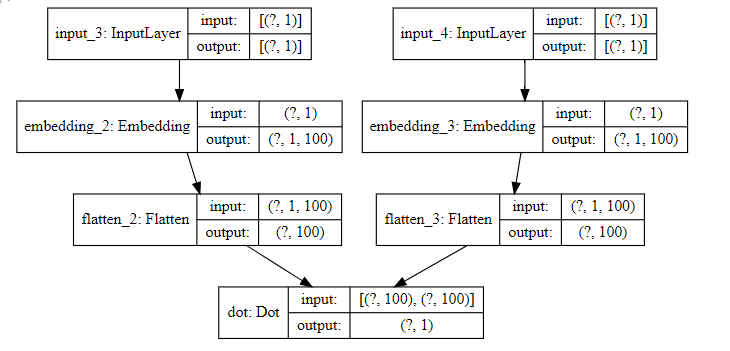

In [ ]:
checkpoint1 = ModelCheckpoint('model1.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [ ]:
%%time
history1 = model1.fit(x=[X_train['user_id'], X_train['anime_id']],
                    y=y_train,
                    batch_size=64,
                    epochs=20,
                    verbose=1,
                    validation_data=([X_val['user_id'], X_val['anime_id']], y_val),
                    callbacks=[checkpoint1])

In [ ]:
# Get training and test loss histories
training_loss1 = history1.history['loss']
test_loss1 = history1.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss1) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss1, 'r--')
plt.plot(epoch_count, test_loss1, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
from keras.models import load_model
model1.save('my_model_new1.h5')

In [ ]:
modelLoaded1 = tf.keras.models.load_model('my_model1.h5')

# 2 модель

In [ ]:
def Recommender2(n_users, n_movies, n_dim):
    
    # User
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    
    # Anime
    movie = Input(shape=(1,))
    M = Embedding(n_movies, n_dim)(movie)
    M = Flatten()(M)
    
    # Gabungkan disini
    merged_vector = concatenate([U, M])
    dense_1 = Dense(128, activation='relu')(merged_vector)
    dropout = Dropout(0.5)(dense_1)
    final = Dense(1)(dropout)
    
    model = Model(inputs=[user, movie], outputs=final)
    
    model.compile(optimizer=Adam(0.001),
                  loss='mean_squared_error')
    
    return model


In [ ]:
model2 = Recommender2(userid_nunique, anime_nunique, 100)
model2.summary()

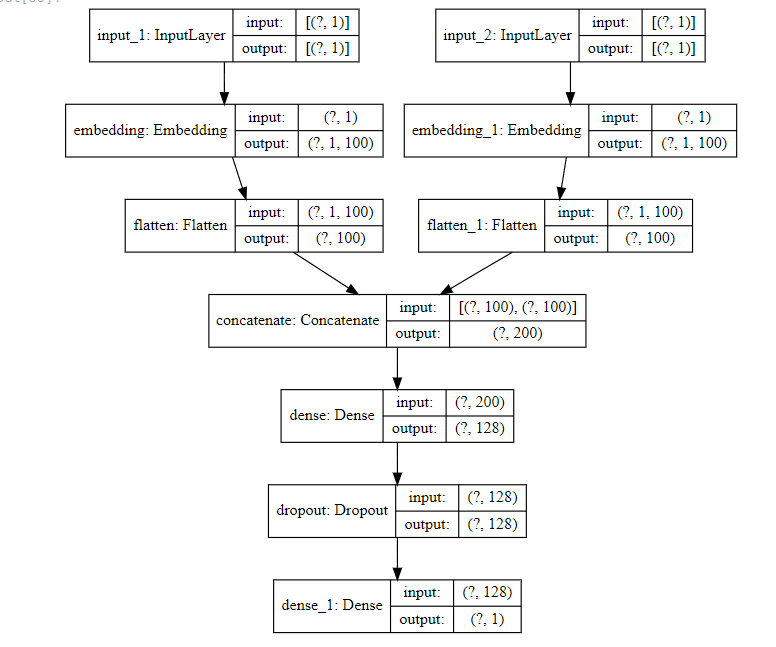

In [ ]:
# model = RecommenderV2(userid_nunique, anime_nunique, 100)

# SVG(model_to_dot(model2, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [ ]:
checkpoint2 = ModelCheckpoint('model2.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [ ]:
%%time
history2 = model2.fit(x=[X_train['user_id'], X_train['anime_id']],
                    y=y_train,
                    batch_size=64,
                    epochs=20,
                    verbose=1,
                    validation_data=([X_val['user_id'], X_val['anime_id']], y_val),
                    callbacks=[checkpoint2])

In [ ]:
# Get training and test loss histories
training_loss2 = history2.history['loss']
test_loss2 = history2.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss2) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss2, 'r--')
plt.plot(epoch_count, test_loss2, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
from keras.models import load_model
model2.save('my_model_new2.h5')

In [ ]:
modelLoaded2 = tf.keras.models.load_model('my_model_new2.h5')

## 3 модель

In [ ]:

def Recommender3(n_users, n_movies, n_dim):
    
    # User
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    U = Dense(64, activation='relu')(U)
    
    # Movie
    movie = Input(shape=(1,))
    M = Embedding(n_movies, n_dim)(movie)
    M = Flatten()(M)
    M = Dense(64, activation='relu')(M)
    
    # Dot U and M
    x = concatenate([U, M])
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    final = Dense(1)(x)
    
    model = Model(inputs=[user, movie], outputs=final)
    
    model.compile(optimizer=Adam(0.0001),
                  loss='mean_squared_error')
    
    return model

In [ ]:
model3 = Recommender3(userid_nunique, anime_nunique, 100)
model3.summary()

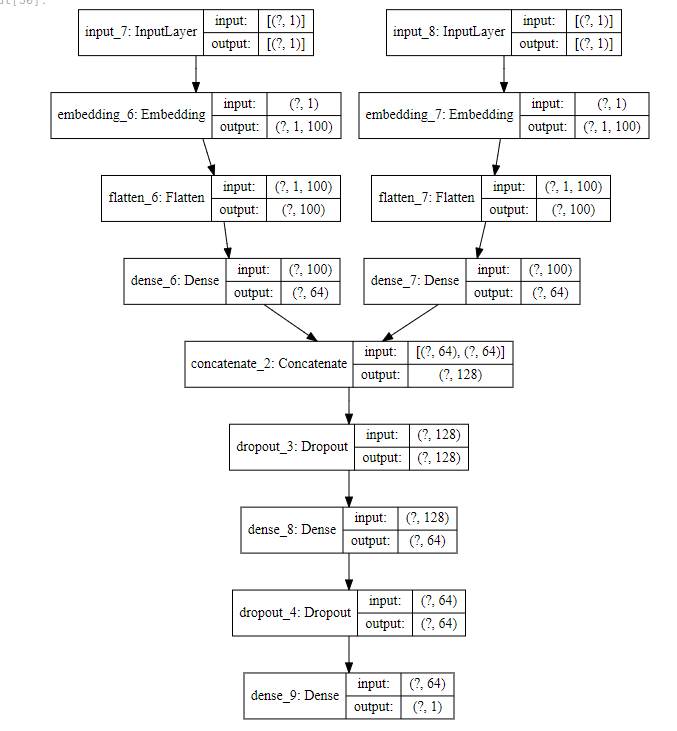

In [ ]:
checkpoint3 = ModelCheckpoint('model3.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [ ]:
%%time
history3 = model3.fit(x=[X_train['user_id'], X_train['anime_id']], y=y_train, batch_size=64, epochs=20,
                      verbose=1, validation_data=([X_val['user_id'], X_val['anime_id']], y_val), callbacks=[checkpoint3])

In [ ]:
# Get training and test loss histories
training_loss3 = history3.history['loss']
test_loss3 = history3.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss3) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss3, 'r--')
plt.plot(epoch_count, test_loss3, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
model3.save('my_model_new3.h5')

In [ ]:
modelLoaded3 = tf.keras.models.load_model('my_model_new3.h5')

In [ ]:
def make_pred(user_id, anime_id, model):
    return model.predict([np.array([user_id]), np.array([anime_id])])[0][0]


In [ ]:
def get_topN_rec(user_id, model):
    
    user_id = int(user_id) - 1
    user_ratings = rating[rating['user_id'] == user_id]
    recommendation = rating[~rating['anime_id'].isin(user_ratings['anime_id'])][['anime_id']].drop_duplicates()
    recommendation['rating_predict'] = recommendation.apply(lambda x: make_pred(user_id, x['anime_id'] , model), axis=1)
    recommendation.loc[:, 'rating_predict'] = recommendation['rating_predict']  -1 
    
    
    final_rec = recommendation.sort_values(by='rating_predict', ascending=False).merge(anime_df[['anime_id', 'name', 'type', 'members']],
                                                                                       on='anime_id').head(10)
    
    return final_rec.sort_values('rating_predict', ascending=False)[['name', 'type', 'rating_predict']]

In [ ]:
%%time
get_topN_rec(123, model1)

In [ ]:
%%time
get_topN_rec(123, model2)

In [ ]:
%%time
get_topN_rec(123, model3)